### Test Preference Model

This is a notebook for testing the functionality of the Preference Model to ensure that it works as intended

In [1]:
import cv2
from PIL import Image
import numpy as np
import numpy.random as npr
import pandas as pd
import os

import matplotlib.pyplot as plt

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

import torch.utils.data
# import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim

import pickle as pkl
import skimage as sk
import skimage.io as skio

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
from preference_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet

# book keeping namings and code
from settings import base_architecture, img_size, prototype_shape, num_classes, \
                     prototype_activation_function, add_on_layers_type, experiment_run

from preprocess import mean, std, preprocess_input_function

In [4]:
normalize = transforms.Normalize(mean=mean,
                                 std=std)

trans = transforms.Compose([
    transforms.Resize(size=(img_size, img_size)),
    transforms.ToTensor(),
    normalize
])

In [5]:
k = 3
csv_name = "../human_comparisons/comparison_009_65+35" + ".csv"
if os.path.exists(csv_name):
    comp_df = pd.read_csv(csv_name)

In [6]:
comp_df

,Unnamed: 0,Unnamed: 0.1,left,right,comp
0,0,0.0,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,0
1,1,0.0,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,1
2,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,1
3,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,0
4,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,1
...,...,...,...,...,...
95,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,0
96,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,-1
97,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,0
98,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,-1


In [7]:
comp_df.iloc[0]['left']

'/scratch/users/jiaxun1218/saved_models/vgg19/009/epoch-100/755/'

In [18]:
def read_row(df, i, k):
    row = df.iloc[i]
    left = row['left']
    lsub_imgs = []
    for j in range(1, k + 1):
        img = left + "/nearest-" + str(j) + "_high_act_patch_in_original_img.png"
    
        img = Image.open(img).convert("RGB")
        img = trans(img)
        lsub_imgs.append(img)
    # each image is (3, 224, 224)
    left = torch.cat(lsub_imgs, axis=1)
    # concatenated shape is (3, 672, 224)
    
    right = row['right']
    rsub_imgs = []
    for j in range(1, k + 1):
        img = right + "/nearest-" + str(j) + "_high_act_patch_in_original_img.png"
    
        img = Image.open(img).convert("RGB")
        img = trans(img)
        rsub_imgs.append(img)
        
    right = torch.cat(rsub_imgs, axis=1)
    target = row['comp']
    return left, right, target

In [19]:
left, right, target = read_row(comp_df, 10, k)
print(left.shape)
left = torch.unsqueeze(left, axis=0)
right = torch.unsqueeze(right, axis=0)

torch.Size([3, 672, 224])
torch.Size([3, 672, 224])


In [10]:
left.shape

torch.Size([1, 3, 672, 224])

In [11]:
prefnet = construct_PrefNet("resnet18")

In [12]:
prefnet

PrefNet(
  (features): resnet18_features
  (add_on_layers): Sequential(
    (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (3): Sigmoid()
  )
  (fc1): Linear(in_features=75264, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)

In [13]:
res = prefnet(left)

In [14]:
res

tensor([[0.1140]], grad_fn=<AddmmBackward>)

In [15]:
prefnet

PrefNet(
  (features): resnet18_features
  (add_on_layers): Sequential(
    (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (3): Sigmoid()
  )
  (fc1): Linear(in_features=75264, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)

In [16]:
comp_df

,Unnamed: 0,Unnamed: 0.1,left,right,comp
0,0,0.0,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,0
1,1,0.0,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,1
2,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,1
3,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,0
4,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,1
...,...,...,...,...,...
95,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,0
96,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,-1
97,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,0
98,0,NaN,/scratch/users/jiaxun1218/saved_models/vgg19/0...,/scratch/users/jiaxun1218/saved_models/vgg19/0...,-1


In [17]:
prefnet = construct_PrefNet("resnet18")
prefnet.to(device)

PrefNet(
  (features): resnet18_features
  (add_on_layers): Sequential(
    (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (3): Sigmoid()
  )
  (fc1): Linear(in_features=75264, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)

In [18]:
prefnet.train()
pref_optimizer = optim.Adam(prefnet.parameters(), lr=0.0001)
epochs = 50

losses = []

In [19]:
### Train the Net for a Bit

for epoch in range(0, epochs):
    for i in range(0, len(comp_df)):
        left, right, target = read_row(comp_df, i, k)
        left = torch.unsqueeze(left, axis=0).to(device).float()
        right = torch.unsqueeze(right, axis=0).to(device).float()
        
        y_comp = torch.tensor(target).to(device).float()

        
        
        out1 = prefnet(left)
        out2 = prefnet(right)



        # in your training loop:
        pref_optimizer.zero_grad()   # zero the gradient buffers

        loss = paired_cross_entropy_loss(out1, out2, y_comp)
        loss.backward()
        pref_optimizer.step()  

        losses.append(loss.data.cpu().numpy()[0])
        
        
        if i % 100 == 0:
            print(epoch, i, np.mean(losses[-100:]))
            print(torch.norm(left - right))
            print(torch.norm(out1.detach() - out2.detach()))
            print("")

0 0 0.69314855
tensor(1223.4838, device='cuda:0')
tensor(0.0033, device='cuda:0')

1 0 0.6934314
tensor(1223.4838, device='cuda:0')
tensor(0.0024, device='cuda:0')

2 0 0.6845602
tensor(1223.4838, device='cuda:0')
tensor(0.0033, device='cuda:0')

3 0 0.5317622
tensor(1223.4838, device='cuda:0')
tensor(0.0758, device='cuda:0')

4 0 0.41204488
tensor(1223.4838, device='cuda:0')
tensor(1.2928, device='cuda:0')

5 0 0.38884154
tensor(1223.4838, device='cuda:0')
tensor(2.1900, device='cuda:0')

6 0 0.37484875
tensor(1223.4838, device='cuda:0')
tensor(0.1032, device='cuda:0')

7 0 0.3645419
tensor(1223.4838, device='cuda:0')
tensor(0.3147, device='cuda:0')

8 0 0.3212919
tensor(1223.4838, device='cuda:0')
tensor(1.0069, device='cuda:0')

9 0 0.30016908
tensor(1223.4838, device='cuda:0')
tensor(5.9128e-05, device='cuda:0')

10 0 0.29651633
tensor(1223.4838, device='cuda:0')
tensor(0.0009, device='cuda:0')

11 0 0.28986847
tensor(1223.4838, device='cuda:0')
tensor(0.0038, device='cuda:0')

12 

In [37]:
torch.save(prefnet.state_dict(), "../human_comparisons/pref_model_009_65+35_ep50_adam_0.0001")

In [22]:
torch.save(prefnet, '../human_comparisons/pref_model_009_65+35_ep50_adam_0.0001_1')

In [38]:
pkl.dump(losses, open("../human_comparisons/pref_model_009_65+35_ep50_adam_0.0001.pkl", "wb"))

In [40]:
#losses

In [46]:
#tmp = pkl.load(open("../datasets/first_pref_model_losses.pkl", "rb"))

In [ ]:
#left.shape, y_comp.shape

In [ ]:
#y_comp

## Evaluate Performance of the Preference Model

In [41]:
prefnet.load_state_dict(torch.load("../human_comparisons/pref_model_009_65+35_ep50_adam_0.0001"))

<All keys matched successfully>

In [49]:
comp_df_test = pd.read_csv("../human_comparisons/comparison_009_2" + ".csv")

In [58]:
prefnet.eval()

acc = []
error_images = []
error_count = 0
for i in range(0, len(comp_df_test)):
    left, right, target = read_row(comp_df_test, i, k)
    
    if target == 0:
        continue
    
    left = torch.unsqueeze(left, axis=0).to(device)
    right = torch.unsqueeze(right, axis=0).to(device)


    out1 = prefnet(left)
    out2 = prefnet(right)
    
    if out1 > out2:
        y_pred = -1
        
    else:
        y_pred = 1
        
    if y_pred == target:
        acc.append(1)
    else:
        error_images.append((i, y_pred, target))
        error_count += 1
        acc.append(0)
    print(out1, out2, target)
        
print(np.mean(acc), error_count)

tensor([[-2.8646]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-2.8510]], device='cuda:0', grad_fn=<AddmmBackward>) 1.0
tensor([[2.9538]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[0.5393]], device='cuda:0', grad_fn=<AddmmBackward>) -1.0
tensor([[2.9495]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-2.5416]], device='cuda:0', grad_fn=<AddmmBackward>) -1.0
tensor([[-2.8548]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[2.7720]], device='cuda:0', grad_fn=<AddmmBackward>) 1.0
tensor([[-0.8003]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[1.6585]], device='cuda:0', grad_fn=<AddmmBackward>) 1.0
tensor([[2.8487]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[2.9371]], device='cuda:0', grad_fn=<AddmmBackward>) 1.0
tensor([[-2.8656]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[2.8029]], device='cuda:0', grad_fn=<AddmmBackward>) 1.0
tensor([[-2.8538]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[2.9559]], device='cuda:0', grad_fn=<Add

In [59]:
error_images

[(17, -1, 1.0), (25, 1, -1.0), (28, 1, -1.0)]

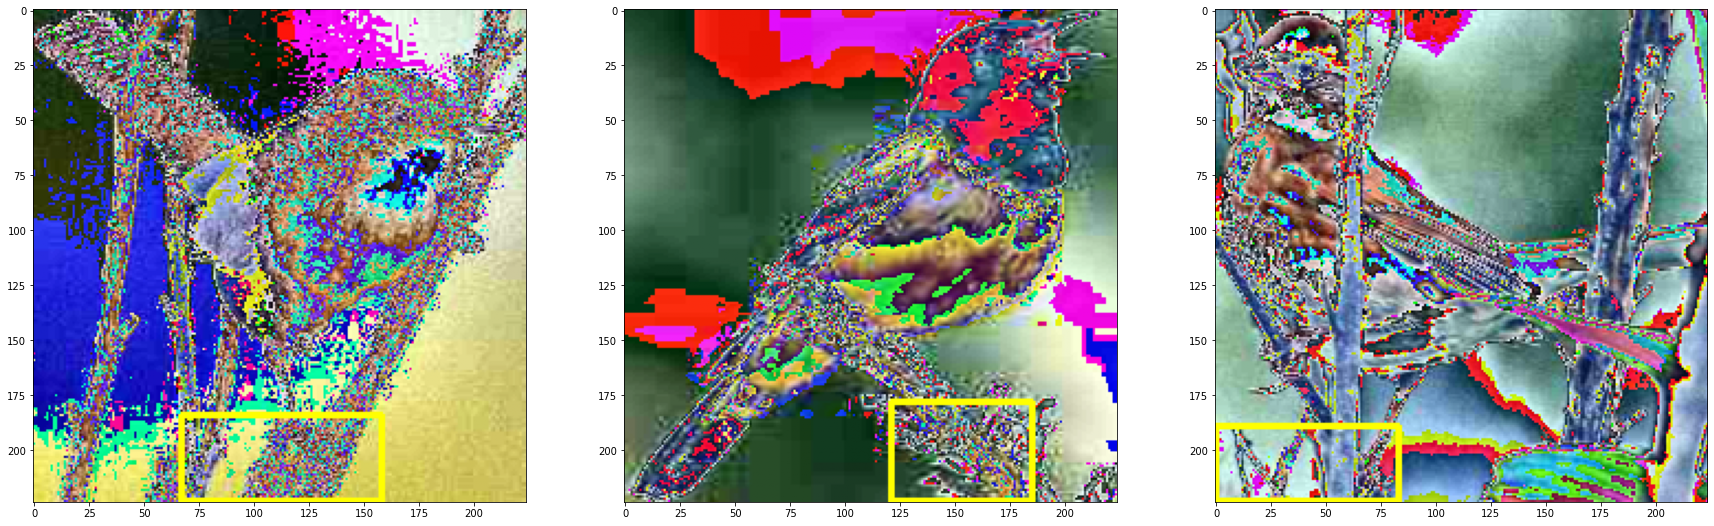

In [68]:
left_prototype = comp_df_test.iloc[28]['left']
right_prototype = comp_df_test.iloc[28]['right']
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for i in range(3):
    img = skio.imread(left_prototype +  "/nearest-" + str(i+1) + "_high_act_patch_in_original_img.png")
    img = sk.img_as_float(img)
    axes[i].imshow(img)

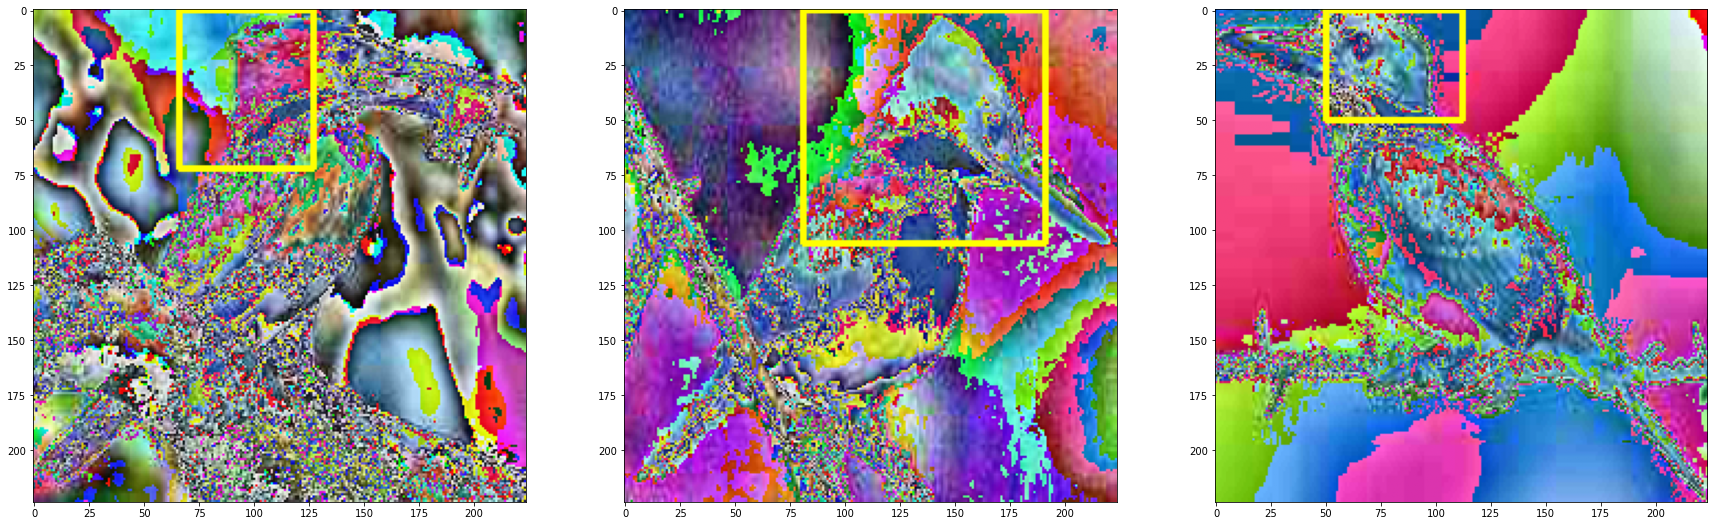

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for i in range(3):
    img = skio.imread(right_prototype +  "/nearest-" + str(i+1) + "_high_act_patch_in_original_img.png")
    img = sk.img_as_float(img)
    axes[i].imshow(img)